# Comparison of models robustness against adv. attacks depending on the optimizer

## Training the models and evaluation on normal test set

### Setup

In [ ]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
from scipy.stats import linregress

In [ ]:
# device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'You are happily using {device}')

You are happily using cuda


In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=2,
                                          pin_memory=True)

testloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform),
                                         batch_size=1024,
                                         shuffle=False,
                                         num_workers=2,
                                         pin_memory=True)

In [ ]:
# Network used
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Set the seeds
def seeding(seed = 1234):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True


### Optimizer list and model parameters

In [ ]:
MODELS = ["AGD", "GD", 'adaptive_support_FISTA', 'adaptive_mu_FISTA', "FISTA", "ISTA"]


In [ ]:
# Define the models used
models = {name: CNN().to(device).to(torch.float32) for name in MODELS}

# Loss function
criterion = nn.CrossEntropyLoss()
seeding()

# Params to go around
lambda_ = 0.001
lr = 0.01
max_iters = 30
tol = 1e-5
SUPPORT = 1e-3
SPARSITY_THRESHOLD = 1e-5

### Operators and Training Loop

In [ ]:
# Proximal Operator
def prox_l1(w, alpha):
    return torch.sign(w) * torch.relu(torch.abs(w) - alpha)

# Training function
def train_optimizer(model, method):

  print('-'*20)
  print(f'Performing calculations for {method}')

  # Xavies initialize
  for param in model.parameters():
    if param.dim() >= 2:
      # Only apply to weight matrices, not biases
      torch.nn.init.xavier_uniform_(param)

  # Params for adaptive_FISTA
  if method == 'adaptive_mu_FISTA':
    L = 10
    alpha_k = 1 / L
    mu = 0.01
    k_iter = 1
    z_k = [p.clone() for p in model.parameters()]

  if method == 'adaptive_support_FISTA':
    L = 10
    alpha_k = 1 / L
    mu = 0.01
    k_iter = 1
    z_k = [p.clone() for p in model.parameters()]
    c = 0.1

  # Params to store
  optimizer, w_old = None, None
  losses, sparsities = [], []
  t = 1

  for epoch in range(max_iters):
    total_loss, total_sparsity = 0, 0
    start_time = time.time()

    for images, labels in trainloader:
      images, labels = images.to(device, dtype=torch.float32, non_blocking=True), labels.to(device)

      optimizer.zero_grad() if optimizer else None
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()


      with torch.no_grad():

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(
            (p for p in model.parameters() if p.dim() >= 2),
            max_norm = 2.0 if method != 'AGD' else 1.0
        )

        sparsity_accumulator = 0  # Accumulate sparsity over all params

        for i, param in enumerate(model.parameters()):

            if param.dim() >= 2:  # Only apply to weights, not biases

              if method == "ISTA":
                  param -= lr * param.grad
                  param.copy_(prox_l1(param, lr * lambda_))

              elif method == "FISTA":
                  z = param.clone()
                  param -= lr * param.grad
                  param.copy_(prox_l1(param, lr * lambda_))
                  t_new = (1 + (1 + 4 * t**2) ** 0.5) / 2
                  z += ((t - 1) / t_new) * (param - z)
                  t = t_new

              elif method == "adaptive_mu_FISTA":

                # Save previous iterate for momentum
                z_prev = z_k[i].clone()

                # Adaptive Step-Size Update
                alpha_k = (1 / L) + k_iter * mu  # Implement Silva & Rodriguez (2019)
                #print(alpha_k)
                alpha_k = min((1 / L) * alpha_k, 1 / L)  # Clipping to prevent divergence

                # Proximal Gradient Step
                param -= alpha_k * param.grad
                param.copy_(prox_l1(param, alpha_k * lambda_))

                # Momentum Update
                t_new = (1 + (1 + 4 * t**2) ** 0.5) / 2
                z_k[i] = param + ((t - 1) / t_new) * (param - z_prev)
                t = t_new

                # Increase iteration counter
                k_iter += 1

              elif method == 'adaptive_support_FISTA':
                # Save previous iterate for momentum
                z_prev = z_k[i].clone()

                # Compute support-based step-size
                s_k = (torch.abs(param) > SUPPORT).float()  # Support of current solution
                g_k = param.grad  # Gradient
                conv_input = s_k * g_k

                # Phi function basically
                if conv_input.dim() == 4:  # If it's a convolutional layer
                  if conv_input.shape[1] != 1:  # Ensure correct number of channels
                    conv_input = conv_input.mean(dim=1, keepdim=True)  # Reduce to 1 channel
                  conv_output = model.conv1(conv_input)  # Apply CNN transformation
                  conv_output = torch.relu(model.bn1(conv_output))
                  conv_output = torch.relu(model.bn2(model.conv2(conv_output)))
                elif conv_input.dim() == 2:  # If it's a fully connected layer
                    conv_input = conv_input.flatten(start_dim=1)  # Ensure correct shape
                    conv_output = model.fc(conv_input)  # Pass through linear layer

                numerator = torch.norm(conv_input) ** 2
                denominator = torch.norm(conv_output) ** 2  # Phi is the linear operator
                alpha_k = c * (numerator / (denominator + 1e-8))

                # Clip step-size to prevent divergence
                alpha_k = min(alpha_k, 1 / L)

                # Proximal Gradient Step
                param -= alpha_k * param.grad
                param.copy_(prox_l1(param, alpha_k * lambda_))

                # Momentum Update
                t_new = (1 + (1 + 4 * t**2) ** 0.5) / 2
                z_k[i] = param + ((t - 1) / t_new) * (param - z_prev)
                t = t_new

                # Increase iteration counter
                k_iter += 1

              elif method == "GD":
                  param -= lr * (param.grad + lambda_ * param)

              elif method == "AGD":
                  if w_old is None:
                      w_old = [p.clone().detach() for p in model.parameters()]

                  agd_learning_rate = lr / 100
                  for i, param in enumerate(model.parameters()):
                      temp = param.clone()
                      param -= agd_learning_rate * (param.grad + lambda_ * param)
                      param += 0.9 * (param - w_old[i])
                      w_old[i] = temp.clone().detach()

      total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)
    losses.append(avg_loss)

    print(f"{method} - Epoch {epoch + 1}: Loss={avg_loss:.4f}, Time={time.time()-start_time:.2f}s")

    if epoch > 1 and np.abs(losses[-1] - losses[-2]) < tol:
        break

  return losses, epoch + 1

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

def train_model_adam(model, device='cuda'):
    print('-' * 20)
    print("Performing calculations for Adam")

    # Xavier initialization for all weights
    for param in model.parameters():
        if param.dim() >= 2:
            torch.nn.init.xavier_uniform_(param)

    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(max_iters):
        total_loss = 0
        start_time = time.time()

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        losses.append(avg_loss)

        print(f"Adam - Epoch {epoch + 1}: Loss={avg_loss:.4f}, Time={time.time() - start_time:.2f}s")

    return losses, epoch + 1


### Training

In [ ]:
results = {}

In [ ]:
# Train models
for method in models:
  results[method] = train_optimizer(
      models[method], method
  )

--------------------
Performing calculations for AGD
AGD - Epoch 1: Loss=0.7776, Time=13.07s
AGD - Epoch 2: Loss=0.2854, Time=11.71s
AGD - Epoch 3: Loss=0.2296, Time=11.66s
AGD - Epoch 4: Loss=0.1961, Time=13.90s
AGD - Epoch 5: Loss=0.1730, Time=12.48s
AGD - Epoch 6: Loss=0.1577, Time=12.16s
AGD - Epoch 7: Loss=0.1471, Time=11.58s
AGD - Epoch 8: Loss=0.1368, Time=11.44s
AGD - Epoch 9: Loss=0.1307, Time=12.48s
AGD - Epoch 10: Loss=0.1212, Time=15.00s
AGD - Epoch 11: Loss=0.1167, Time=11.82s
AGD - Epoch 12: Loss=0.1128, Time=11.59s
AGD - Epoch 13: Loss=0.1054, Time=11.56s
AGD - Epoch 14: Loss=0.0997, Time=11.76s
AGD - Epoch 15: Loss=0.0957, Time=12.62s
AGD - Epoch 16: Loss=0.0887, Time=11.29s
AGD - Epoch 17: Loss=0.0845, Time=11.14s
AGD - Epoch 18: Loss=0.0798, Time=11.43s
AGD - Epoch 19: Loss=0.0762, Time=11.49s
AGD - Epoch 20: Loss=0.0704, Time=11.50s
AGD - Epoch 21: Loss=0.0642, Time=11.78s
AGD - Epoch 22: Loss=0.0636, Time=11.82s
AGD - Epoch 23: Loss=0.0566, Time=11.62s
AGD - Epoch 2

In [ ]:
MODELS.append("ADAM")
models["ADAM"] = CNN().to(device).to(torch.float32)

In [ ]:
results['ADAM'] = train_model_adam(models['ADAM'])

--------------------
Performing calculations for Adam
Adam - Epoch 1: Loss=1.9517, Time=10.95s
Adam - Epoch 2: Loss=0.0880, Time=10.72s
Adam - Epoch 3: Loss=0.0517, Time=10.43s
Adam - Epoch 4: Loss=0.0377, Time=10.13s
Adam - Epoch 5: Loss=0.0271, Time=10.69s
Adam - Epoch 6: Loss=0.0223, Time=10.68s
Adam - Epoch 7: Loss=0.0192, Time=10.65s
Adam - Epoch 8: Loss=0.0192, Time=10.82s
Adam - Epoch 9: Loss=0.0167, Time=10.57s
Adam - Epoch 10: Loss=0.0121, Time=10.18s
Adam - Epoch 11: Loss=0.0144, Time=10.99s
Adam - Epoch 12: Loss=0.0141, Time=10.75s
Adam - Epoch 13: Loss=0.0091, Time=10.78s
Adam - Epoch 14: Loss=0.0103, Time=10.95s
Adam - Epoch 15: Loss=0.0123, Time=10.93s
Adam - Epoch 16: Loss=0.0097, Time=10.39s
Adam - Epoch 17: Loss=0.0094, Time=10.57s
Adam - Epoch 18: Loss=0.0115, Time=10.87s
Adam - Epoch 19: Loss=0.0132, Time=10.81s
Adam - Epoch 20: Loss=0.0096, Time=10.87s
Adam - Epoch 21: Loss=0.0063, Time=10.87s
Adam - Epoch 22: Loss=0.0104, Time=10.88s
Adam - Epoch 23: Loss=0.0108, T

### Model evaluation and training results on test dataset

In [ ]:
# Evaluate models
def get_test_accuracy_and_sparsity(model, sparsity_threshold = SPARSITY_THRESHOLD):
    model.eval()
    correct, total = 0, 0
    total_sparsity = 0  # Track overall sparsity

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device, dtype=torch.float32, non_blocking=True), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute sparsity across all parameters
        total_params, zero_params = 0, 0
        for param in model.parameters():
            total_params += param.numel()
            zero_params += (torch.abs(param) < sparsity_threshold).sum().item()

        sparsity = (zero_params / total_params)

    return correct / total, sparsity


In [ ]:
test_accuracies = {
    name : get_test_accuracy_and_sparsity(model) for name, model in models.items()
}

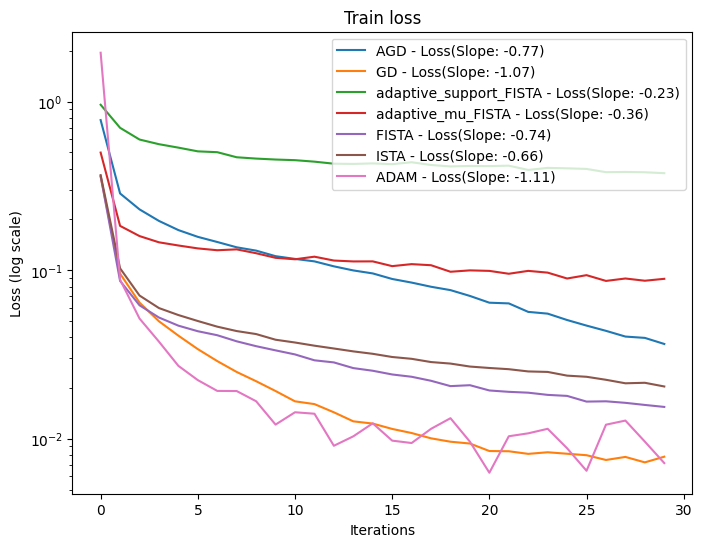

In [ ]:
# Plot results
fig, ax1 = plt.subplots(figsize=(8,6))

for name, (losses, stop_iter) in results.items():

    iterations = np.arange(1, len(losses) + 1)  # Iteration numbers

    log_iters = np.log(iterations)
    log_losses = np.log(losses)

    # Supposing rate of convergence should be O(1/t^r) --> slope of logfit should be -r
    # e.g. AGD should have emipirical slope close to -2
    slope, intercept, _, _, _ = linregress(log_iters, log_losses)

    ax1.plot(losses, label=f"{name} - Loss(Slope: {slope:.2f})")
    #ax1.scatter(stop_iter, losses[stop_iter-1], marker='o', s=100, label=f"{name} Stop")

ax1.set_yscale('log')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss (log scale)')
ax1.set_title('Train loss')
#ax1.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax1.legend()
plt.show()

In [ ]:
# Result in a table
SPARSITY_THRESHOLD = 1e-5
table_data = []
for name, (accuracy, sparsity) in test_accuracies.items():
    table_data.append([name, sparsity * 100, accuracy * 100])

df_results = pd.DataFrame(table_data, columns=["Algorithm", "Final Sparsity (%)", "Test Accuracy (%)"])
df_results.round(3)

,Algorithm,Final Sparsity (%),Test Accuracy (%)
0,AGD,0.062,97.27
1,GD,0.064,97.76
2,adaptive_support_FISTA,46.868,69.58
3,adaptive_mu_FISTA,19.695,97.67
4,FISTA,37.666,98.20
5,ISTA,43.787,98.25
6,ADAM,0.012,98.19


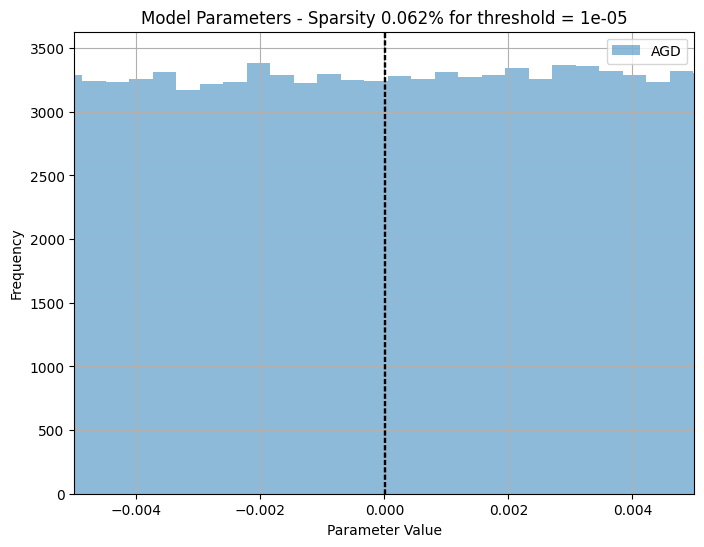

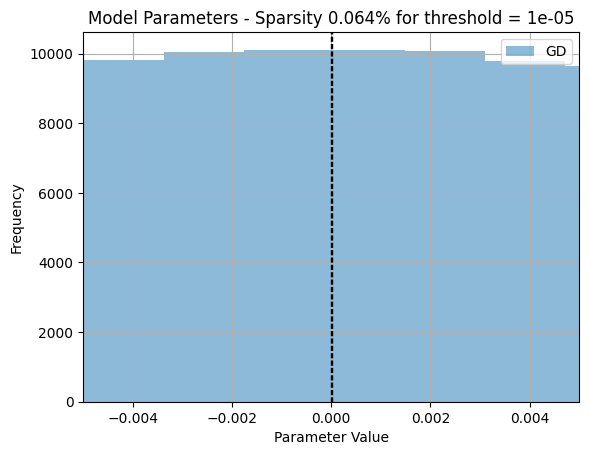

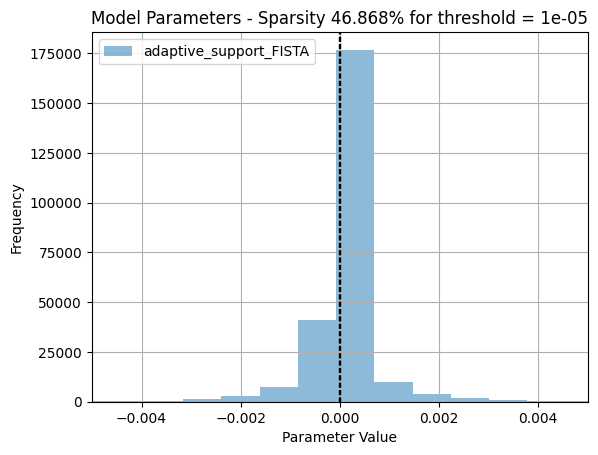

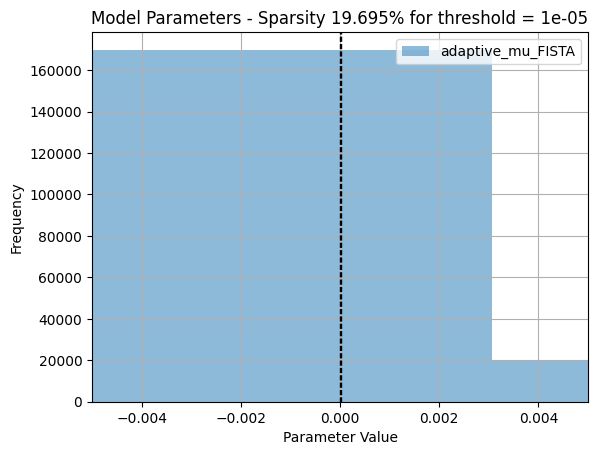

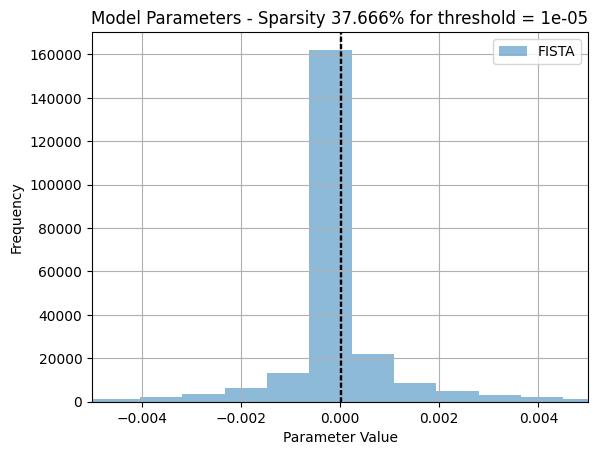

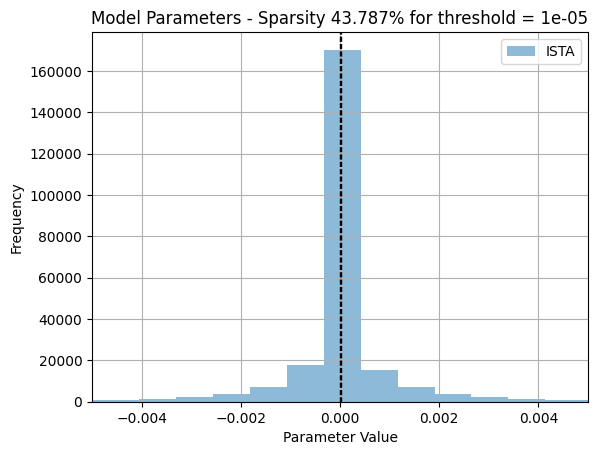

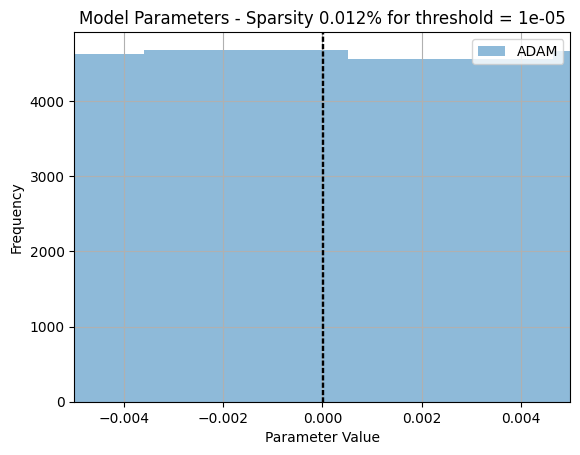

In [ ]:
def flatten_params(model):
    return torch.cat([param.view(-1).detach().cpu() for param in model.parameters() if param.dim() >= 2])

# Loop over models and plot histograms
plt.figure(figsize=(8, 6))

for method, model in models.items():
  params = flatten_params(model).numpy()
  plt.hist(params, bins=1000, alpha=0.5, label=method)
  a = 500
  plt.xlim(-a * SPARSITY_THRESHOLD, a * SPARSITY_THRESHOLD)
  plt.axvline(x=SPARSITY_THRESHOLD, color="black", linestyle="dashed", linewidth=1)
  plt.axvline(x=-SPARSITY_THRESHOLD, color="black", linestyle="dashed", linewidth=1)

  plt.xlabel("Parameter Value")
  plt.ylabel("Frequency")
  name = df_results['Final Sparsity (%)'][df_results['Algorithm'] == method].round(3).values[0]
  plt.title(f"Model Parameters - Sparsity {name}% for threshold = {SPARSITY_THRESHOLD}")
  plt.legend()
  plt.grid()
  plt.show()


## Save models and load them back


### Save models

In [ ]:
import torch
import os

# Directory to save models
os.makedirs("saved_models", exist_ok=True)

# Save all trained models
for name, model in models.items():
    path = f"saved_models/{name}.pt"
    torch.save(model.state_dict(), path)

# Create a zip file for download
!zip -r models.zip saved_models

  adding: saved_models/ (stored 0%)
  adding: saved_models/AGD.pt (deflated 8%)
  adding: saved_models/ISTA.pt (deflated 37%)
  adding: saved_models/adaptive_support_FISTA.pt (deflated 41%)
  adding: saved_models/GD.pt (deflated 7%)
  adding: saved_models/adaptive_mu_FISTA.pt (deflated 21%)
  adding: saved_models/FISTA.pt (deflated 31%)
  adding: saved_models/ADAM.pt (deflated 7%)


In [ ]:
from google.colab import files
files.download("models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Upload models

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import torch
import os
import zipfile

# Unzip the uploaded models
with zipfile.ZipFile("models.zip", 'r') as zip_ref:
    zip_ref.extractall("saved_models")

# Re-initialize the models
models = {name: CNN().to(device).to(torch.float32) for name in MODELS}

# Load saved weights
for name in MODELS:
    path = f"saved_models/saved_models/{name}.pt"
    models[name].load_state_dict(torch.load(path, map_location=device))


## Model robustness test against adversarial attack

### Setup

#### Installation

In [ ]:
# Get adversarial attack library
!pip install git+https://github.com/jeromerony/adversarial-library

  Cloning https://github.com/jeromerony/adversarial-library to /tmp/pip-req-build-k6bts8z0
  Running command git clone --filter=blob:none --quiet https://github.com/jeromerony/adversarial-library /tmp/pip-req-build-k6bts8z0
  Resolved https://github.com/jeromerony/adversarial-library to commit 4ca9b77bb6c909d47e161ced0e257c6003fb4116
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install psutil

#### Setup

In [ ]:
# Prepare set of images to be attacked
inputs, labels = next(iter(testloader))
inputs, labels = inputs.to(device), labels.to(device)

### Generic functions for all attacks.

In [ ]:
from adv_lib.attacks import (
    deepfool,
    carlini_wagner_linf,
    carlini_wagner_l2,
    pgd_linf,
    str_attack,
    ddn,
    tr,
    fab,
    perc_al,
    apgd,
    alma,
    fmn,
    pdgd,
    pdpgd,
    sdf,
    sigma_zero
)

In [ ]:
# Optional: put all attacks in a dictionary for easy access

# Commented out - bugged out in a weird way
ATTACKS = {
    # "deepfool": deepfool,
    "carlini_wagner_linf": carlini_wagner_linf,
    "carlini_wagner_l2": carlini_wagner_l2,
    "pgd_linf": pgd_linf,
    "str_attack": str_attack,
    "ddn": ddn,
    "tr": tr,
    "fab": fab,
#    "perc_al": perc_al,
    "apgd": apgd,
    "alma": alma,
    "fmn": fmn,
    "pdgd": pdgd,
    "pdpgd": pdpgd,
    "sdf": sdf,
    "sigma_zero": sigma_zero
}


In [ ]:
def get_adv_examples(inputs, labels, attack_name):
    """
    Runs a specified adversarial attack on a set of models.

    Args:
        inputs: Input tensors (e.g., images).
        labels: Ground truth labels.
        attack_name: Name of the attack (must match one in ATTACKS).

    Returns:
        Dictionary mapping model names to their adversarial examples.
    """
    if attack_name not in ATTACKS:
        raise ValueError(f"Unsupported attack '{attack_name}'. Choose from: {list(ATTACKS.keys())}")

    attack_fn = ATTACKS[attack_name]
    adv_samples_dict = {}

    for method, model in models.items():
        print(f"Running {attack_name} attack for model: {method}")

        adv_samples = attack_fn(model=model, inputs=inputs, labels=labels)
        adv_samples_dict[method] = adv_samples

    return adv_samples_dict


def run_all_attacks(inputs, labels, models, save_dir="adv_results", attack_configs=None, check_existing=True):
    """
    Run all attacks from ATTACKS on each model and save results.

    Args:
        inputs: Input tensors.
        labels: Ground truth labels.
        models: Dict of model_name -> model instance.
        save_dir: Directory to save results.
        attack_configs: Optional dict of attack_name -> dict of extra args to pass.
        check_existing: If True, load from disk if adv file already exists.

    Returns:
        Nested dict: results[attack_name][model_name] = adv_examples or None if failed.
    """
    import os
    import torch

    os.makedirs(save_dir, exist_ok=True)
    results = {}
    attack_configs = attack_configs or {}

    for attack_name, attack_fn in ATTACKS.items():
        print(f"\n=== Running attack: {attack_name} ===")
        results[attack_name] = {}

        attack_args = attack_configs.get(attack_name, {})

        for model_name, model in models.items():
            print(f" -> Model: {model_name}")
            save_path = os.path.join(save_dir, f"{attack_name}_{model_name}.pt")

            # 🔁 Load if existing and allowed
            if check_existing and os.path.exists(save_path):
                try:
                    adv_samples = torch.load(save_path)
                    results[attack_name][model_name] = adv_samples
                    print(f"    [📂] Loaded: {save_path}")
                    continue
                except Exception as e:
                    print(f"    [!] Failed to load existing file: {e}, regenerating...")

            try:
                # 🧼 Clamp inputs
                inputs = torch.clamp(inputs, 0.0, 1.0)

                # 🔀 Special-case API differences
                if attack_name == "perc_al":
                    adv_samples = attack_fn(
                        model=model,
                        images=inputs,
                        num_classes=10,
                        labels=labels,
                        **attack_args
                    )
                else:
                    adv_samples = attack_fn(
                        model=model,
                        inputs=inputs,
                        labels=labels,
                        **attack_args
                    )

                # 🧼 Clamp outputs
                adv_samples = torch.clamp(adv_samples, 0.0, 1.0)

                # Save & store
                torch.save(adv_samples, save_path)
                results[attack_name][model_name] = adv_samples
                print(f"    [✓] Saved: {save_path}")

            except Exception as e:
                print(f"    [!] Failed: {attack_name} on {model_name} — {e}")
                results[attack_name][model_name] = None

    return results


In [ ]:
attack_configs = {
    "fab": {"norm": 2},
    "apgd": {"eps": 0.1, "norm": 2},
    "fmn": {"norm": 2},
    "pdpgd": {"norm": 2},
    "carlini_wagner_linf": {"max_iterations": 50},
    "carlini_wagner_l2": {"max_iterations": 50},
    "pgd_linf": {"ε": 0.1},
    "str_attack": {"max_iterations": 50},

}

In [ ]:
adv_results = run_all_attacks(inputs, labels, models, save_dir="adv_examples", attack_configs=attack_configs)


=== Running attack: carlini_wagner_linf ===
 -> Model: AGD
    [📂] Loaded: adv_examples/carlini_wagner_linf_AGD.pt
 -> Model: GD
    [📂] Loaded: adv_examples/carlini_wagner_linf_GD.pt
 -> Model: adaptive_support_FISTA
    [📂] Loaded: adv_examples/carlini_wagner_linf_adaptive_support_FISTA.pt
 -> Model: adaptive_mu_FISTA
    [📂] Loaded: adv_examples/carlini_wagner_linf_adaptive_mu_FISTA.pt
 -> Model: FISTA
    [📂] Loaded: adv_examples/carlini_wagner_linf_FISTA.pt
 -> Model: ISTA
    [📂] Loaded: adv_examples/carlini_wagner_linf_ISTA.pt
 -> Model: ADAM
    [✓] Saved: adv_examples/carlini_wagner_linf_ADAM.pt

=== Running attack: carlini_wagner_l2 ===
 -> Model: AGD
    [📂] Loaded: adv_examples/carlini_wagner_l2_AGD.pt
 -> Model: GD
    [📂] Loaded: adv_examples/carlini_wagner_l2_GD.pt
 -> Model: adaptive_support_FISTA
    [📂] Loaded: adv_examples/carlini_wagner_l2_adaptive_support_FISTA.pt
 -> Model: adaptive_mu_FISTA
    [📂] Loaded: adv_examples/carlini_wagner_l2_adaptive_mu_FISTA.pt
 -> 

In [ ]:
import shutil
from google.colab import files

folder_to_download = "adv_examples"
output_filename = f"{folder_to_download}.zip"
shutil.make_archive(folder_to_download, 'zip', folder_to_download)
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import os
import torch

def load_adv_results(save_dir="adv_examples"):
    """
    Loads adversarial examples saved in the format <attack>_<model>.pt

    Args:
        save_dir: Directory where .pt files are saved.

    Returns:
        Nested dict: loaded[attack_name][model_name] = adv_examples
    """
    loaded = {}

    for file in os.listdir(save_dir):
        if file.endswith(".pt"):
            try:
                # Extract attack and model name from filename
                name_parts = file[:-3].split("_")  # remove .pt and split
                attack_name = "_".join(name_parts[:-1])
                model_name = name_parts[-1]

                # Load file
                file_path = os.path.join(save_dir, file)
                adv_samples = torch.load(file_path)

                # Store in nested dictionary
                if attack_name not in loaded:
                    loaded[attack_name] = {}
                loaded[attack_name][model_name] = adv_samples

                print(f"[✓] Loaded: {file_path}")
            except Exception as e:
                print(f"[!] Failed to load {file}: {e}")

    return loaded


In [ ]:
import matplotlib.pyplot as plt
import torch
import os

import os
import torch
import matplotlib.pyplot as plt

def show_and_save_adv_examples(
    adv_samples_dict, inputs, labels, models, name, index=0,
    norm='l2', save_dir="adv_visuals",
):
    """
    Generate and save adversarial example comparisons.

    Args:
        adv_samples_dict: Dict of attack_name -> adv_tensor
        inputs: Clean input tensor
        labels: Ground truth labels
        models: Dict of attack_name -> model
        index: Which input sample to visualize
        norm: 'l2' or 'linf'
        save_dir: Where to save the images
    """
    def img_tensor_to_np(tensor):
        if tensor.shape[0] == 1:
            return tensor.squeeze().numpy()
        else:
            return tensor.permute(1, 2, 0).numpy()

    os.makedirs(save_dir, exist_ok=True)
    orig = inputs[index].detach().cpu()

    fig, axs = plt.subplots(2, len(adv_samples_dict), figsize=(4 * len(adv_samples_dict), 6))
    if len(adv_samples_dict) == 1:
        axs = axs.reshape(2, 1)  # Fix shape for single attack case

    for method_idx, (method, adv) in enumerate(adv_samples_dict.items()):
        if adv is None:
            continue

        model = models[method]
        model.eval()

        adv_ex = adv[index].detach().cpu()
        diff = adv_ex - orig

        # Norm calculation
        if norm == 'l2':
            diff_norm = torch.norm(diff).item()
            norm_name = "L2"
        elif norm == 'linf':
            diff_norm = diff.abs().max().item()
            norm_name = "L∞"
        else:
            raise ValueError("Unsupported norm.")

        # Model prediction
        with torch.no_grad():
            adv_input = adv_ex.unsqueeze(0).to(next(model.parameters()).device)
            pred = model(adv_input).argmax(dim=1).item()

        axs[0, method_idx].imshow(img_tensor_to_np(adv_ex), cmap='gray')
        axs[0, method_idx].set_title(f"{method}\n→ Class {pred}\n{norm_name}={diff_norm:.4f}")
        axs[0, method_idx].axis('off')

        axs[1, method_idx].imshow(img_tensor_to_np(diff.abs() * 5), cmap='hot')
        axs[1, method_idx].axis('off')

    axs[0, 0].set_ylabel("Row 1: Original Images", fontsize=12, rotation=0, ha='right')
    axs[1, 0].set_ylabel("Row 2: Difference Heatmaps", fontsize=12, rotation=0, ha='right')


    plt.suptitle(f"Adversarial Examples (Index {index})", fontsize=16)
    plt.tight_layout()

    # Save the image
    save_path = os.path.join(save_dir, f"adv_comparison_{name}_idx{index}.png")
    plt.savefig(save_path)
    plt.close()
    print(f"[✓] Saved visualization to {save_path}")



In [ ]:
index_to_visualize = 500
# For each attack, build a dict of {attack_name: adv_tensor}
for attack_name in adv_results:
    show_and_save_adv_examples(
        adv_samples_dict=adv_results[attack_name],
        inputs=inputs,
        labels=labels,
        models=models,
        name=attack_name,
        index=index_to_visualize,
        norm='l2',
        save_dir="adv_viz",
    )

[✓] Saved visualization to adv_viz/adv_comparison_carlini_wagner_linf_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_carlini_wagner_l2_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_pgd_linf_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_str_attack_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_ddn_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_tr_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_fab_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_apgd_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_alma_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_fmn_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_pdgd_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_pdpgd_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_sdf_idx500.png
[✓] Saved visualization to adv_viz/adv_comparison_sigma_zero_idx500.png


In [ ]:
import shutil
from google.colab import files

folder_to_download = "adv_viz"
output_filename = f"{folder_to_download}.zip"
shutil.make_archive(folder_to_download, 'zip', folder_to_download)
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import json
import os

def evaluate_adversarial_effectiveness(adv_samples_dict, inputs, labels, models, norm='l2', save_path="adv_eval_results/eval_results.json"):
    inputs = inputs.detach().cpu()
    labels = labels.detach().cpu()

    results = {}

    print("📊 Adversarial Attack Evaluation:\n")

    for method, adv in adv_samples_dict.items():
        model = models[method]
        model.eval()

        adv = adv.detach().cpu()

        norms = []
        incorrect = 0
        total = inputs.size(0)

        for i in range(total):
            orig = inputs[i]
            adv_ex = adv[i]
            diff = adv_ex - orig

            # Compute norm
            if norm == 'l2':
                diff_norm = torch.norm(diff).item()
            elif norm == 'linf':
                diff_norm = diff.abs().max().item()
            else:
                raise ValueError("Unsupported norm. Use 'l2' or 'linf'.")
            norms.append(diff_norm)

            # Prediction on adversarial example
            with torch.no_grad():
                adv_input = adv_ex.unsqueeze(0).to(next(model.parameters()).device)
                pred_label = model(adv_input).argmax(dim=1).item()

            if pred_label != labels[i].item():
                incorrect += 1

        avg_norm = sum(norms) / len(norms)
        fool_rate = incorrect / total * 100

        results[method] = {
            'average_norm': avg_norm,
            'fooling_rate_percent': fool_rate,
            'incorrect': incorrect,
            'total': total,
            'norm_type': norm
        }

        # Print results
        print(f"🔹 {method}:")
        print(f"   • Avg. {norm.upper()} Norm: {avg_norm:.4f}")
        print(f"   • Fooling Rate: {fool_rate:.2f}% ({incorrect}/{total})\n")

    # Save to JSON file
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "w") as f:
        json.dump(results, f, indent=4)
    print(f"✅ Evaluation results saved to: {save_path}")

    return results


In [ ]:
for attack_name in adv_results:
    evaluate_adversarial_effectiveness(
        adv_samples_dict=adv_results[attack_name],
        inputs=inputs,
        labels=labels,
        models=models,
        norm='l2',
        save_path=f"adv_eval_results/eval_results_{attack_name}.json",
    )

📊 Adversarial Attack Evaluation:

🔹 AGD:
   • Avg. L2 Norm: 25.7930
   • Fooling Rate: 83.79% (858/1024)

🔹 GD:
   • Avg. L2 Norm: 25.8443
   • Fooling Rate: 90.92% (931/1024)

🔹 adaptive_support_FISTA:
   • Avg. L2 Norm: 25.7695
   • Fooling Rate: 55.37% (567/1024)

🔹 adaptive_mu_FISTA:
   • Avg. L2 Norm: 25.9060
   • Fooling Rate: 90.62% (928/1024)

🔹 FISTA:
   • Avg. L2 Norm: 25.7827
   • Fooling Rate: 87.99% (901/1024)

🔹 ISTA:
   • Avg. L2 Norm: 25.7805
   • Fooling Rate: 64.84% (664/1024)

🔹 ADAM:
   • Avg. L2 Norm: 25.7516
   • Fooling Rate: 50.00% (512/1024)

✅ Evaluation results saved to: adv_eval_results/eval_results_carlini_wagner_linf.json
📊 Adversarial Attack Evaluation:

🔹 AGD:
   • Avg. L2 Norm: 25.6842
   • Fooling Rate: 83.79% (858/1024)

🔹 GD:
   • Avg. L2 Norm: 25.6835
   • Fooling Rate: 88.38% (905/1024)

🔹 adaptive_support_FISTA:
   • Avg. L2 Norm: 25.6829
   • Fooling Rate: 25.78% (264/1024)

🔹 adaptive_mu_FISTA:
   • Avg. L2 Norm: 25.6831
   • Fooling Rate: 86.91

In [ ]:
import shutil
from google.colab import files

folder_to_download = "adv_eval_results"
output_filename = f"{folder_to_download}.zip"
shutil.make_archive(folder_to_download, 'zip', folder_to_download)
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import torch
import os

def cross_examine_attacks(models, adv_samples_dict, inputs, labels, norm='l2', save_path='adv_eval/cross_examination'):
    inputs = inputs.detach().cpu()
    labels = labels.detach().cpu()
    data = []

    for method, adv in adv_samples_dict.items():
        adv = adv.detach().cpu()

        for test_model_name, model in models.items():
            model.eval()

            incorrect = 0
            total = inputs.size(0)

            for i in range(total):
                orig = inputs[i]
                adv_ex = adv[i]
                diff = adv_ex - orig

                if norm == 'l2':
                    _ = torch.norm(diff).item()  # Not used, could be logged if needed
                elif norm == 'linf':
                    _ = diff.abs().max().item()

                with torch.no_grad():
                    adv_input = adv_ex.unsqueeze(0).to(next(model.parameters()).device)
                    pred_label = model(adv_input).argmax(dim=1).item()

                if pred_label != labels[i].item():
                    incorrect += 1

            fool_rate = incorrect / total * 100

            data.append({
                'Test Model': test_model_name,
                'Attack Method': method,
                'Fooling Rate (%)': fool_rate
            })

    df = pd.DataFrame(data)

    # Pivot table for cross-model comparison
    cross_examination_df = df.pivot(index='Test Model', columns='Attack Method', values='Fooling Rate (%)')
    cross_examination_df = cross_examination_df.sort_index(axis=0).sort_index(axis=1)

    # Save to file
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    csv_path = f"{save_path}.csv"
    xlsx_path = f"{save_path}.xlsx"

    cross_examination_df.to_csv(csv_path)
    cross_examination_df.to_excel(xlsx_path)

    print(f"✅ Cross-examination table saved to:\n - {csv_path}\n - {xlsx_path}")

    return cross_examination_df


In [ ]:
for attack_name in adv_results:
    cross_examine_attacks(
        adv_samples_dict=adv_results[attack_name],
        inputs=inputs,
        labels=labels,
        models=models,
        norm='l2',
        save_path=f"adv_eval/cross_examination_{attack_name}",
    )

✅ Cross-examination table saved to:
 - adv_eval/cross_examination_carlini_wagner_linf.csv
 - adv_eval/cross_examination_carlini_wagner_linf.xlsx
✅ Cross-examination table saved to:
 - adv_eval/cross_examination_carlini_wagner_l2.csv
 - adv_eval/cross_examination_carlini_wagner_l2.xlsx
✅ Cross-examination table saved to:
 - adv_eval/cross_examination_pgd_linf.csv
 - adv_eval/cross_examination_pgd_linf.xlsx
✅ Cross-examination table saved to:
 - adv_eval/cross_examination_str_attack.csv
 - adv_eval/cross_examination_str_attack.xlsx
✅ Cross-examination table saved to:
 - adv_eval/cross_examination_ddn.csv
 - adv_eval/cross_examination_ddn.xlsx
✅ Cross-examination table saved to:
 - adv_eval/cross_examination_tr.csv
 - adv_eval/cross_examination_tr.xlsx
✅ Cross-examination table saved to:
 - adv_eval/cross_examination_fab.csv
 - adv_eval/cross_examination_fab.xlsx
✅ Cross-examination table saved to:
 - adv_eval/cross_examination_apgd.csv
 - adv_eval/cross_examination_apgd.xlsx
✅ Cross-exam

In [ ]:
import shutil
from google.colab import files

folder_to_download = "adv_eval"
output_filename = f"{folder_to_download}.zip"
shutil.make_archive(folder_to_download, 'zip', folder_to_download)
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Analysis and auto-article generation

In [ ]:
# import zipfile
# import os
# from google.colab import files

# uploaded = files.upload()

# for filename in uploaded.keys():
#     if filename.endswith(".zip"):
#         extract_dir = filename.replace(".zip", "")
#         os.makedirs(extract_dir, exist_ok=True)
#         with zipfile.ZipFile(filename, 'r') as zip_ref:
#             zip_ref.extractall(extract_dir)
#         print(f"Extracted to: {extract_dir}")


In [ ]:
import os
import json
from collections import defaultdict

# Step 1: Set your extracted directory
extracted_dir = "adv_eval_results"  # Replace with your actual directory if different

# Step 2: Collect evaluation results from all files
combined_results = defaultdict(dict)  # model_name -> {attack_name: metrics}

# Loop through all eval_results_*.json files
for fname in os.listdir(extracted_dir):
    if fname.startswith("eval_results_") and fname.endswith(".json"):
        attack_name = fname[len("eval_results_"):-len(".json")]
        filepath = os.path.join(extracted_dir, fname)

        with open(filepath, "r") as f:
            attack_results = json.load(f)

        for model_name, metrics in attack_results.items():
            combined_results[model_name][attack_name] = metrics

# Optional: convert defaultdict to regular dict
combined_results = dict(combined_results)

# Check result structure
for model_name, attacks in combined_results.items():
    print(f"\n🧠 Model: {model_name}")
    for attack_name, metrics in attacks.items():
        print(f"  • {attack_name}: Fooling rate = {metrics['fooling_rate_percent']:.2f}%, Norm = {metrics['average_norm']:.2f}")



🧠 Model: AGD
  • carlini_wagner_linf: Fooling rate = 83.79%, Norm = 25.79
  • fmn: Fooling rate = 83.59%, Norm = 25.68
  • fab: Fooling rate = 83.79%, Norm = 25.78
  • apgd: Fooling rate = 83.79%, Norm = 25.70
  • tr: Fooling rate = 83.59%, Norm = 25.71
  • pdgd: Fooling rate = 83.79%, Norm = 25.78
  • pdpgd: Fooling rate = 83.79%, Norm = 25.80
  • str_attack: Fooling rate = 83.79%, Norm = 25.77
  • alma: Fooling rate = 83.79%, Norm = 25.78
  • sigma_zero: Fooling rate = 85.45%, Norm = 26.27
  • carlini_wagner_l2: Fooling rate = 83.79%, Norm = 25.68
  • sdf: Fooling rate = 83.79%, Norm = 25.79
  • ddn: Fooling rate = 83.79%, Norm = 25.80
  • pgd_linf: Fooling rate = 87.11%, Norm = 26.39

🧠 Model: GD
  • carlini_wagner_linf: Fooling rate = 90.92%, Norm = 25.84
  • fmn: Fooling rate = 88.28%, Norm = 25.70
  • fab: Fooling rate = 90.33%, Norm = 25.87
  • apgd: Fooling rate = 88.28%, Norm = 25.68
  • tr: Fooling rate = 88.48%, Norm = 25.71
  • pdgd: Fooling rate = 90.62%, Norm = 25.92
  •

In [ ]:
import pandas as pd
import os
import json
from collections import defaultdict

# Load evaluation results as before
extracted_dir = "adv_eval_results"
fooling_rates = defaultdict(dict)  # attack_name -> model_name -> fooling rate

# Step 1: Load fooling rates into dictionary
for fname in os.listdir(extracted_dir):
    if fname.startswith("eval_results_") and fname.endswith(".json"):
        attack_name = fname[len("eval_results_"):-len(".json")]
        filepath = os.path.join(extracted_dir, fname)

        with open(filepath, "r") as f:
            data = json.load(f)

        for model_name, metrics in data.items():
            fooling_rates[attack_name][model_name] = metrics["fooling_rate_percent"]

# Step 2: Convert to Pandas DataFrame
df = pd.DataFrame.from_dict(fooling_rates, orient='index')
df = df.sort_index(axis=0).sort_index(axis=1)  # Optional: sort rows and columns
df = df.round(2)

# Step 3: Display
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=["Attack ↓"] + list(df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.index] + [df[col] for col in df.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title="📊 Fooling Rates (%) by Model and Attack")
fig.show()

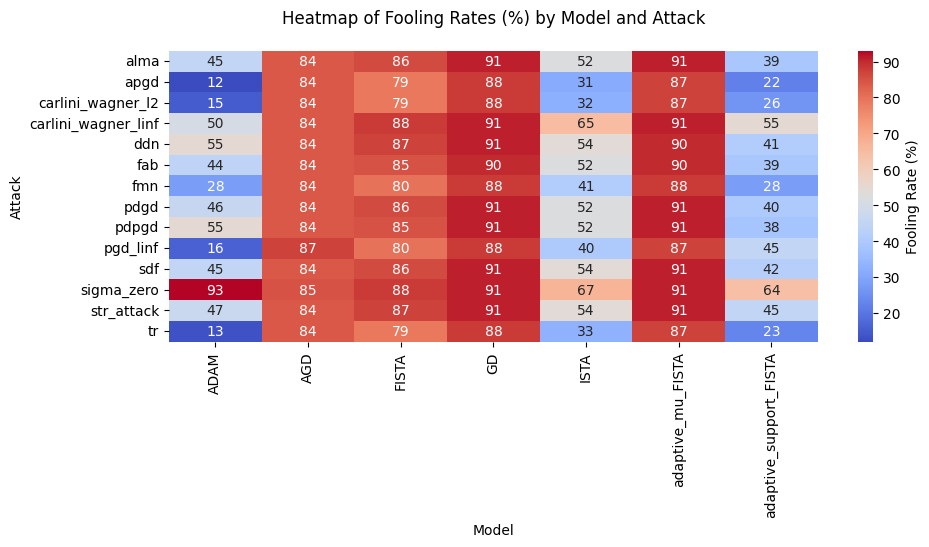

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 4: Create heatmap with rounded integers
plt.figure(figsize=(10, 6))

sns.heatmap(
    df.round(0).astype(int),  # Round to nearest integer
    annot=True,
    fmt="d",                  # Format as integer
    cmap="coolwarm",
    cbar_kws={'label': 'Fooling Rate (%)'}
)

plt.title("Heatmap of Fooling Rates (%) by Model and Attack", pad=20)
plt.xlabel("Model")
plt.ylabel("Attack")
plt.tight_layout(rect=[0, 0.02, 1, 0.95])  # Top spacing for title

plt.show()

In [ ]:
def dataframe_to_latex_table(df, caption="Fooling rates (%) by model and attack", label="tab:fooling_rates"):
    latex_code = []

    # Begin LaTeX table environment
    latex_code.append("\\begin{table}[htbp]")
    latex_code.append("\\centering")
    latex_code.append("\\small")  # Smaller font (optional)
    latex_code.append(f"\\caption{{{caption}}}")
    latex_code.append(f"\\label{{{label}}}")

    # Begin tabular
    cols = ['Attack'] + list(df.columns)
    num_cols = len(cols)
    col_format = 'l' + 'c' * (num_cols - 1)
    latex_code.append(f"\\begin{{tabular}}{{{col_format}}}")
    latex_code.append("\\toprule")

    # Header row
    header_row = " & ".join(cols) + " \\\\"
    latex_code.append(header_row)
    latex_code.append("\\midrule")

    # Data rows
    for idx, row in df.iterrows():
        row_values = [str(idx)] + [f"{v:.0f}" if pd.notnull(v) else "--" for v in row]
        latex_code.append(" & ".join(row_values) + " \\\\")

    # End tabular
    latex_code.append("\\bottomrule")
    latex_code.append("\\end{tabular}")
    latex_code.append("\\end{table}")

    # Join everything
    return "\n".join(latex_code)

In [ ]:
latex_code = dataframe_to_latex_table(df)
print(latex_code)

\begin{table}[htbp]
\centering
\small
\caption{Fooling rates (%) by model and attack}
\label{tab:fooling_rates}
\begin{tabular}{lccccccc}
\toprule
Attack & ADAM & AGD & FISTA & GD & ISTA & adaptive_mu_FISTA & adaptive_support_FISTA \\
\midrule
alma & 45 & 84 & 86 & 91 & 52 & 91 & 39 \\
apgd & 12 & 84 & 79 & 88 & 31 & 87 & 22 \\
carlini_wagner_l2 & 15 & 84 & 79 & 88 & 32 & 87 & 26 \\
carlini_wagner_linf & 50 & 84 & 88 & 91 & 65 & 91 & 55 \\
ddn & 55 & 84 & 87 & 91 & 54 & 90 & 41 \\
fab & 44 & 84 & 85 & 90 & 52 & 90 & 39 \\
fmn & 28 & 84 & 80 & 88 & 41 & 88 & 28 \\
pdgd & 46 & 84 & 86 & 91 & 52 & 91 & 40 \\
pdpgd & 55 & 84 & 85 & 91 & 52 & 91 & 38 \\
pgd_linf & 16 & 87 & 80 & 88 & 40 & 87 & 45 \\
sdf & 45 & 84 & 86 & 91 & 54 & 91 & 42 \\
sigma_zero & 93 & 85 & 88 & 91 & 67 & 91 & 64 \\
str_attack & 47 & 84 & 87 & 91 & 54 & 91 & 45 \\
tr & 13 & 84 & 79 & 88 & 33 & 87 & 23 \\
\bottomrule
\end{tabular}
\end{table}


In [ ]:
import os
import pandas as pd

def load_cross_examination_data(folder):
    dataframes = {}
    for filename in os.listdir(folder):
        if filename.startswith("cross_examination_") and filename.endswith(".csv"):
            attack_name = filename[len("cross_examination_"):-len(".csv")]
            path = os.path.join(folder, filename)
            df = pd.read_csv(path)
            dataframes[attack_name] = df
    return dataframes


In [ ]:
def dataframe_to_latex(df, caption="Cross-examination results", label="tab:cross_exam"):
    latex_lines = []
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append("\\scriptsize")  # Shrink to fit slide
    latex_lines.append(f"\\caption{{{caption}}}")
    latex_lines.append(f"\\label{{{label}}}")

    col_format = 'l' + 'c' * (df.shape[1] - 1)
    latex_lines.append(f"\\begin{{tabular}}{{{col_format}}}")
    latex_lines.append("\\toprule")

    headers = " & ".join(df.columns) + " \\\\"
    latex_lines.append(headers)
    latex_lines.append("\\midrule")

    for _, row in df.iterrows():
        row_str = " & ".join( f"{int(v)}" if isinstance(v, (int, float)) and not pd.isnull(v) else str(v) for v in row) + " \\\\"
        latex_lines.append(row_str)

    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\end{table}")

    return "\n".join(latex_lines)


In [ ]:
# Set path to the extracted directory
extracted_dir = "adv_eval"  # <-- update this if needed

# Load all data
cross_exam_dfs = load_cross_examination_data(extracted_dir)

# Print LaTeX tables
for attack, df in cross_exam_dfs.items():
    caption = f"Cross-examination results for {attack}"
    label = f"tab:cross_exam_{attack}"
    latex_code = dataframe_to_latex(df, caption=caption, label=label)
    print(f"\n% ====== {attack.upper()} ======\n")
    print(latex_code)
    print("\n% ============================\n")



% ====== SDF ======

\begin{table}[htbp]
\centering
\scriptsize
\caption{Cross-examination results for sdf}
\label{tab:cross_exam_sdf}
\begin{tabular}{lccccccc}
\toprule
Test Model & ADAM & AGD & FISTA & GD & ISTA & adaptive_mu_FISTA & adaptive_support_FISTA \\
\midrule
ADAM & 45 & 11 & 19 & 19 & 23 & 18 & 15 \\
AGD & 84 & 83 & 84 & 84 & 84 & 83 & 85 \\
FISTA & 84 & 79 & 85 & 82 & 86 & 82 & 83 \\
GD & 90 & 88 & 90 & 90 & 90 & 89 & 90 \\
ISTA & 43 & 32 & 42 & 40 & 54 & 38 & 39 \\
adaptive_mu_FISTA & 90 & 87 & 90 & 89 & 90 & 90 & 89 \\
adaptive_support_FISTA & 26 & 22 & 25 & 25 & 27 & 24 & 42 \\
\bottomrule
\end{tabular}
\end{table}

% ============================


% ====== CARLINI_WAGNER_L2 ======

\begin{table}[htbp]
\centering
\scriptsize
\caption{Cross-examination results for carlini_wagner_l2}
\label{tab:cross_exam_carlini_wagner_l2}
\begin{tabular}{lccccccc}
\toprule
Test Model & ADAM & AGD & FISTA & GD & ISTA & adaptive_mu_FISTA & adaptive_support_FISTA \\
\midrule
ADAM & 15 & 1

In [ ]:
def load_cross_examination_data(folder):
    dataframes = {}
    for filename in os.listdir(folder):
        if filename.startswith("cross_examination_") and filename.endswith(".csv"):
            attack_name = filename[len("cross_examination_"):-len(".csv")]
            path = os.path.join(folder, filename)
            df = pd.read_csv(path, index_col=0)

            # Ensure all values are numeric (skip string columns like "Test Model")
            df = df.apply(pd.to_numeric, errors='coerce')

            dataframes[attack_name] = df
    return dataframes

In [ ]:
def compute_average_cross_examination(dataframes, save_path="adv_eval/cross_examination_average"):
    if not dataframes:
        raise ValueError("No dataframes to average.")

    # Align all DataFrames and compute element-wise mean
    aligned = [df.sort_index().sort_index(axis=1) for df in dataframes.values()]
    average_df = sum(aligned) / len(aligned)

    # Save
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    average_df.to_csv(f"{save_path}.csv")
    average_df.to_excel(f"{save_path}.xlsx")

    print(f"✅ Average fooling rate saved to:\n - {save_path}.csv\n - {save_path}.xlsx")
    return average_df


In [ ]:
folder = "adv_eval"
dfs = load_cross_examination_data(folder)
average_df = compute_average_cross_examination(dfs)

✅ Average fooling rate saved to:
 - adv_eval/cross_examination_average.csv
 - adv_eval/cross_examination_average.xlsx


In [ ]:
!pip install seaborn matplotlib

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, title="Average Fooling Rates", cmap="coolwarm", save_path=None):
    plt.figure(figsize=(10, 6))

    # Draw the heatmap
    ax = sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar_kws={'label': 'Fooling Rate (%)'}
    )

    # Set title at top with padding
    ax.set_title(title, fontsize=14, pad=20, loc='center')

    # Set axis labels
    ax.set_ylabel("Test Model")
    ax.set_xlabel("Attack Method")

    # Tight layout with less bottom margin
    plt.tight_layout(rect=[0, 0.02, 1, 0.95])  # [left, bottom, right, top]

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Heatmap saved to: {save_path}")

    plt.show()


✅ Heatmap saved to: adv_eval/fooling_rate_heatmap.png


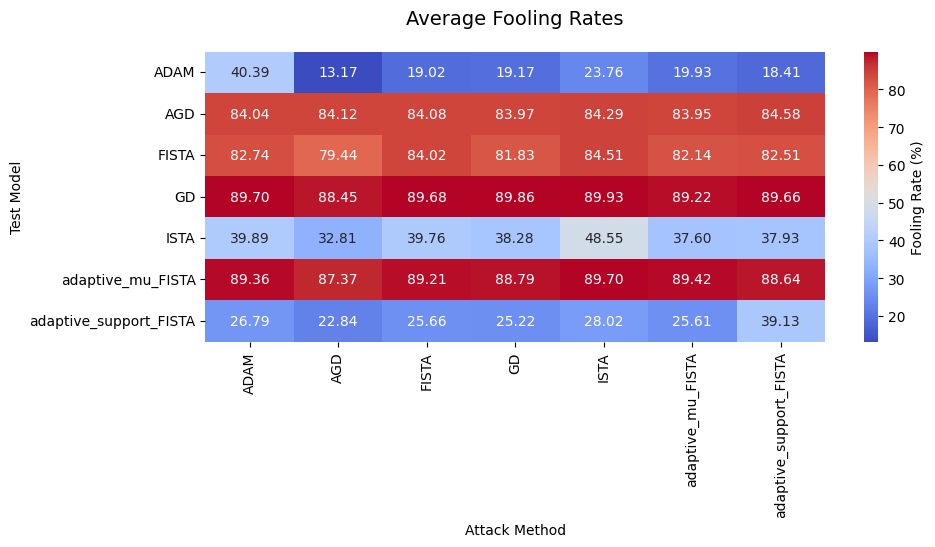

In [ ]:
plot_heatmap(average_df, save_path="adv_eval/fooling_rate_heatmap.png")